In [1]:
from pulp import *
from alb_tools import *
import itertools
from more_itertools import set_partitions

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [2]:
#instance_names = ['SALBP_benchmark/small data set_n=20/instance_n=20_1.alb','SALBP_benchmark/small data set_n=20/instance_n=20_2.alb' ]
instance_names = ['SALBP_benchmark/debugging_ds/instance_n=5_1.alb','SALBP_benchmark/debugging_ds/instance_n=5_2.alb' ]
test_instances = create_instance_pairs(instance_names)
NO_EQUIPMENT = 4
NO_S = 2
C_EM = 150
NO_MODELS = 2
TAKT_TIME = 250 #cadence to respect
MAX_L = 3 #maximum number of workers at a station
#STATION_MODEL_PICTURES  = {}

S_E = [(s, e ) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s , l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS ** NO_S #Number of possible line pictures

test_instances[0]= eliminate_tasks(test_instances[0], (0,0))
for i in range(NO_MODELS):
    test_instances[0][i]['cycle_time'] = TAKT_TIME
    test_instances[0][i]['c_em'] = C_EM
    test_instances[0][i]['max_workers'] = MAX_L

all_tasks = list_all_tasks(test_instances[0]) 

c_se, r_oe = generate_equipment(NO_EQUIPMENT,NO_S, all_tasks)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe('', omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))


In [3]:
print(test_instances)

[[{'num_tasks': 5, 'cycle_time': 250, 'order_strength': 0.268, 'task_times': {'1': 142, '2': 34, '3': 140, '4': 214, '5': 121}, 'precedence_relations': [('1', '2'), ('1', '3'), ('3', '5'), ('4', '5')], 'model_no': 0, 'c_em': 150, 'max_workers': 3}, {'num_tasks': 5, 'cycle_time': 250, 'order_strength': 0.3, 'task_times': {'1': 58, '2': 224, '3': 20, '4': 150, '5': 410}, 'precedence_relations': [('1', '4'), ('2', '5'), ('3', '4'), ('3', '5')], 'model_no': 1, 'c_em': 150, 'max_workers': 3}]]


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_71963/1903328287.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


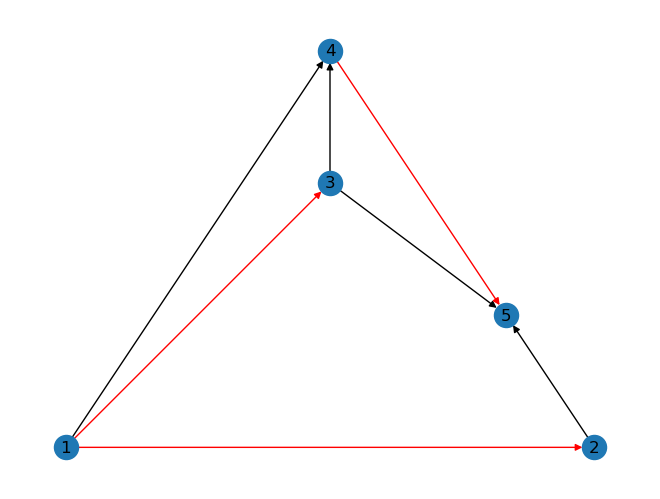

In [4]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]['precedence_relations'], color = 'r')
p_graph.add_edges_from(test_instances[0][1]['precedence_relations'], color= 'k')
colors = [p_graph[u][v]['color'] for u,v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
plt.savefig("precedence_graph.png", format="PNG" )

In [5]:
test_instances[0]

[{'num_tasks': 5,
  'cycle_time': 250,
  'order_strength': 0.268,
  'task_times': {'1': 142, '2': 34, '3': 140, '4': 214, '5': 121},
  'precedence_relations': [('1', '2'), ('1', '3'), ('3', '5'), ('4', '5')],
  'model_no': 0,
  'c_em': 150,
  'max_workers': 3},
 {'num_tasks': 5,
  'cycle_time': 250,
  'order_strength': 0.3,
  'task_times': {'1': 58, '2': 224, '3': 20, '4': 150, '5': 410},
  'precedence_relations': [('1', '4'), ('2', '5'), ('3', '4'), ('3', '5')],
  'model_no': 1,
  'c_em': 150,
  'max_workers': 3}]

In [6]:
feasible_partitions = {}

for model in models:
    partitions = []
    task_partitioning(partitions, [[] for _ in range(NO_S)], list(all_tasks), NO_S,  test_instances[0][model])
    feasible_partitions[f'model_{model}'] = partitions

In [7]:
feasible_partitions

{'model_0': [[['2', '4', '1', '3'], ['5']],
  [['2', '4', '1'], ['5', '3']],
  [['2', '1', '3'], ['4', '5']],
  [['2', '1'], ['4', '5', '3']],
  [['4', '1', '5', '3'], ['2']],
  [['4', '1', '3'], ['2', '5']],
  [['4', '1'], ['2', '5', '3']],
  [['4'], ['2', '1', '5', '3']],
  [['1', '3'], ['2', '4', '5']],
  [['1'], ['2', '4', '5', '3']]],
 'model_1': [[['2', '4', '1', '3'], ['5']],
  [['2', '1', '5', '3'], ['4']],
  [['2', '1', '3'], ['4', '5']],
  [['2', '1'], ['4', '5', '3']],
  [['2', '5', '3'], ['4', '1']],
  [['2', '3'], ['4', '1', '5']],
  [['2'], ['4', '1', '5', '3']],
  [['4', '1', '3'], ['2', '5']]]}

## MDP State
### State variables
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise


R_osa -- equal to 1 if action a performs task o on the model in station s



### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a


### Other parameters
q_as -- number of workers required in station s for action a






## STATE markov decision process

In [9]:
no_line_pictures = len(omega)
no_line_pictures

4

In [10]:
def create_model_histories(feasible_partitions, models, NO_S):
    model_histories = {}
    for model in models:
            feasible_histories = []
            for index, partition in enumerate(feasible_partitions[f'model_{model}']):
                feasible_history = {}
                feasible_history['index'] = index
                feasible_history['station_0'] = []
                completed_tasks = partition[0]
                for station in range(1,NO_S):
                    feasible_history[f'station_{station}'] = completed_tasks.copy()
                    completed_tasks = completed_tasks + partition[station]
                feasible_histories.append(feasible_history)
            model_histories[f'model_{model}'] = feasible_histories
    return model_histories
model_histories = create_model_histories(feasible_partitions,models, NO_S)
model_histories


{'model_0': [{'index': 0, 'station_0': [], 'station_1': ['2', '4', '1', '3']},
  {'index': 1, 'station_0': [], 'station_1': ['2', '4', '1']},
  {'index': 2, 'station_0': [], 'station_1': ['2', '1', '3']},
  {'index': 3, 'station_0': [], 'station_1': ['2', '1']},
  {'index': 4, 'station_0': [], 'station_1': ['4', '1', '5', '3']},
  {'index': 5, 'station_0': [], 'station_1': ['4', '1', '3']},
  {'index': 6, 'station_0': [], 'station_1': ['4', '1']},
  {'index': 7, 'station_0': [], 'station_1': ['4']},
  {'index': 8, 'station_0': [], 'station_1': ['1', '3']},
  {'index': 9, 'station_0': [], 'station_1': ['1']}],
 'model_1': [{'index': 0, 'station_0': [], 'station_1': ['2', '4', '1', '3']},
  {'index': 1, 'station_0': [], 'station_1': ['2', '1', '5', '3']},
  {'index': 2, 'station_0': [], 'station_1': ['2', '1', '3']},
  {'index': 3, 'station_0': [], 'station_1': ['2', '1']},
  {'index': 4, 'station_0': [], 'station_1': ['2', '5', '3']},
  {'index': 5, 'station_0': [], 'station_1': ['2', '

In [11]:

def create_picture_hist(picture, D, d, d_count, model_histories, current_station, no_s):
    if current_station == no_s:
            d_copy = copy.deepcopy(d)
            d_copy['index'] = d_count
            D.append(d_copy)
            return d_count + 1
    for history in model_histories[f'model_{picture[current_station]}']:
        d_copy = copy.deepcopy(d)
        d_copy[f'model_at_{current_station}'] = picture[current_station]
        d_copy[f'history_at_{current_station}'] = history[f'station_{current_station}']
        d_count = create_picture_hist(picture, D, d_copy, d_count, model_histories, current_station + 1, no_s)
    return d_count
D = []
d_count = 0
for picture in omega:
    picture_hist = []
    d_count = create_picture_hist(picture, picture_hist, {},d_count,  model_histories, 0, NO_S)
    D = D + picture_hist

In [12]:
D

[{'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '4', '1', '3'],
  'index': 0},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '4', '1'],
  'index': 1},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1', '3'],
  'index': 2},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['2', '1'],
  'index': 3},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['4', '1', '5', '3'],
  'index': 4},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['4', '1', '3'],
  'index': 5},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['4', '1'],
  'index': 6},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['4'],
  'index': 7},
 {'model_at_0': '0',
  'history_at_0': [],
  'model_at_1': '0',
  'history_at_1': ['1', '3'],
  'i

In [13]:
len(D)

324

In [14]:
def calculate_time_and_workers(tasks, instance, model, takt_time, max_workers):
    total_time = 0
    for task in tasks:
        total_time += instance[model]['task_times'][task]
    workers = 1

    while total_time / workers > takt_time:
        workers += 1
        if workers > max_workers:
             return total_time, None, None
    reduced_time = total_time / workers
    return total_time, reduced_time, workers


def create_actions(d, A, a, a_count,num_workers, instance, takt_time, max_workers,  model_histories, current_station, no_s):

    if current_station == no_s:
            a_copy = copy.deepcopy(a)
            a_copy['action_index'] = str(d['index']) + '_' + str(a_count)
            a_copy['total_workers'] = num_workers
            A.append(a_copy)
            return a_count + 1
    if current_station > 0 and not a[f'reduced_time_at_{current_station-1}']:
        return a_count
    
    for history in model_histories[f'model_{d[f"model_at_{current_station}"]}']:
        if d[f'history_at_{current_station}'] == history[f'station_{current_station}']:
            a_copy = copy.deepcopy(a)
            model_at_station = d[f'model_at_{current_station}']
            a_copy[f'model_at_{current_station}'] = model_at_station
            if current_station < no_s - 1:
                a_copy[f'history_at_{current_station}'] = d[f'history_at_{current_station}']
                a_copy[f'action_at_{current_station}'] =list(set(history[f'station_{current_station + 1}']) - set(d[f'history_at_{current_station}'])  )
            else:
                 a_copy[f'history_at_{current_station}'] = d[f'history_at_{current_station}']
                 a_copy[f'action_at_{current_station}'] =list(set(all_tasks) - set(d[f'history_at_{current_station}']))
            a_copy[f'total_task_time_at_{current_station}'], a_copy[f'reduced_time_at_{current_station}'], a_copy[f'workers_at_{current_station}'] = calculate_time_and_workers(a_copy[f'action_at_{current_station}'], instance, int(model_at_station), takt_time, max_workers)
            if a_copy[f'reduced_time_at_{current_station}']:
                 num_workers += a_copy[f'workers_at_{current_station}']
            a_count = create_actions(d, A, a_copy, a_count, num_workers, instance, takt_time, max_workers,  model_histories, current_station + 1, no_s)
    return a_count
A = []
a_count = 0
for d in D:
    action = []
    a_count = create_actions(d, action, {}, a_count,0, test_instances[0], TAKT_TIME, MAX_L, model_histories, 0, NO_S)
    A = A + action


In [15]:
len(A)

2952

In [37]:
def calculate_transistion_probabilities_2_stations(A,D, model_distribution= (0.4, 0.6)):
    for index, action in enumerate(A):
        
        for d in D:
            print('d', d)
            print('a', action['model_at_0'])
            if d == 'model_' + str(action['model_at_0']):
                print(D[d])
    return
calculate_transistion_probabilities_2_stations(A, model_histories)

d model_0
a 0
[{'index': 0, 'station_0': [], 'station_1': ['2', '4', '1', '3']}, {'index': 1, 'station_0': [], 'station_1': ['2', '4', '1']}, {'index': 2, 'station_0': [], 'station_1': ['2', '1', '3']}, {'index': 3, 'station_0': [], 'station_1': ['2', '1']}, {'index': 4, 'station_0': [], 'station_1': ['4', '1', '5', '3']}, {'index': 5, 'station_0': [], 'station_1': ['4', '1', '3']}, {'index': 6, 'station_0': [], 'station_1': ['4', '1']}, {'index': 7, 'station_0': [], 'station_1': ['4']}, {'index': 8, 'station_0': [], 'station_1': ['1', '3']}, {'index': 9, 'station_0': [], 'station_1': ['1']}]
d model_1
a 0
d model_0
a 0
[{'index': 0, 'station_0': [], 'station_1': ['2', '4', '1', '3']}, {'index': 1, 'station_0': [], 'station_1': ['2', '4', '1']}, {'index': 2, 'station_0': [], 'station_1': ['2', '1', '3']}, {'index': 3, 'station_0': [], 'station_1': ['2', '1']}, {'index': 4, 'station_0': [], 'station_1': ['4', '1', '5', '3']}, {'index': 5, 'station_0': [], 'station_1': ['4', '1', '3']}, 

# MDP Milp
whew, finally
W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

In [27]:
X_ad =LpVariable.dicts('X_ad', (action['action_index'] for action in A), lowBound=0, upBound=1, cat=LpContinuous )
W_se = LpVariable.dicts('W_se', (S_E), lowBound=0, upBound=1, cat=LpBinary )

{(0, 0): W_se_(0,_0),
 (0, 1): W_se_(0,_1),
 (0, 2): W_se_(0,_2),
 (0, 3): W_se_(0,_3),
 (1, 0): W_se_(1,_0),
 (1, 1): W_se_(1,_1),
 (1, 2): W_se_(1,_2),
 (1, 3): W_se_(1,_3)}

{'0_0': X_ad_0_0,
 '0_1': X_ad_0_1,
 '0_2': X_ad_0_2,
 '0_3': X_ad_0_3,
 '0_4': X_ad_0_4,
 '0_5': X_ad_0_5,
 '0_6': X_ad_0_6,
 '0_7': X_ad_0_7,
 '0_8': X_ad_0_8,
 '0_9': X_ad_0_9,
 '1_10': X_ad_1_10,
 '1_11': X_ad_1_11,
 '1_12': X_ad_1_12,
 '1_13': X_ad_1_13,
 '1_14': X_ad_1_14,
 '1_15': X_ad_1_15,
 '1_16': X_ad_1_16,
 '1_17': X_ad_1_17,
 '1_18': X_ad_1_18,
 '1_19': X_ad_1_19,
 '2_20': X_ad_2_20,
 '2_21': X_ad_2_21,
 '2_22': X_ad_2_22,
 '2_23': X_ad_2_23,
 '2_24': X_ad_2_24,
 '2_25': X_ad_2_25,
 '2_26': X_ad_2_26,
 '2_27': X_ad_2_27,
 '2_28': X_ad_2_28,
 '2_29': X_ad_2_29,
 '3_30': X_ad_3_30,
 '3_31': X_ad_3_31,
 '3_32': X_ad_3_32,
 '3_33': X_ad_3_33,
 '3_34': X_ad_3_34,
 '3_35': X_ad_3_35,
 '3_36': X_ad_3_36,
 '3_37': X_ad_3_37,
 '3_38': X_ad_3_38,
 '3_39': X_ad_3_39,
 '4_40': X_ad_4_40,
 '4_41': X_ad_4_41,
 '4_42': X_ad_4_42,
 '4_43': X_ad_4_43,
 '4_44': X_ad_4_44,
 '4_45': X_ad_4_45,
 '4_46': X_ad_4_46,
 '4_47': X_ad_4_47,
 '4_48': X_ad_4_48,
 '4_49': X_ad_4_49,
 '5_50': X_ad_5_50,
